## Swin Transformer

Using device: cpu


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Best model saved at epoch 1
Epoch [1/10]:
  Train Loss: 0.0458, Train Accuracy: 0.9838
  Val Loss: 0.0005, Val Accuracy: 1.0000
----------------------------------------
Epoch [2/10]:
  Train Loss: 0.0003, Train Accuracy: 1.0000
  Val Loss: 0.0000, Val Accuracy: 1.0000
----------------------------------------
Epoch [3/10]:
  Train Loss: 0.0078, Train Accuracy: 0.9983
  Val Loss: 0.0001, Val Accuracy: 1.0000
----------------------------------------
Epoch [4/10]:
  Train Loss: 0.0271, Train Accuracy: 0.9925
  Val Loss: 0.0036, Val Accuracy: 1.0000
----------------------------------------
Epoch [5/10]:
  Train Loss: 0.0166, Train Accuracy: 0.9954
  Val Loss: 0.0081, Val Accuracy: 0.9967
----------------------------------------
Epoch [6/10]:
  Train Loss: 0.0086, Train Accuracy: 0.9971
  Val Loss: 0.1790, Val Accuracy: 0.9767
----------------------------------------
Epoch [7/10]:
  Train Loss: 0.0097, Train Accuracy: 0.9988
  Val Loss: 0.0054, Val Accuracy: 0.9967
--------------------------

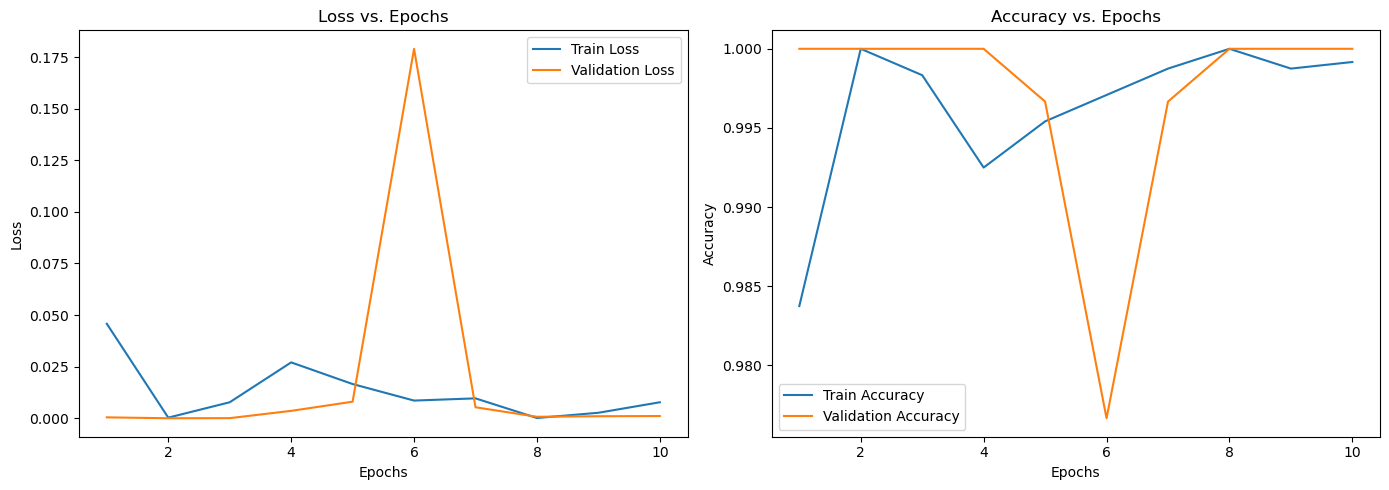

Training Complete. Plots saved as JPG.


In [1]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from transformers import SwinForImageClassification, AutoImageProcessor
from torch import nn
from torch.optim import AdamW
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Set paths
train_path = 'F:/Volcanic Activity Detection/LastUpdate/train'
test_path = 'F:/Volcanic Activity Detection/LastUpdate/test'

# Force CPU usage
device = torch.device("cpu")
print(f"Using device: {device}")

# Set manual seed for reproducibility
torch.manual_seed(42)

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
train_dataset = ImageFolder(root=train_path, transform=transform)
test_dataset = ImageFolder(root=test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Initialize Swin Transformer model
model_name = "microsoft/swin-tiny-patch4-window7-224"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = SwinForImageClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification
    ignore_mismatched_sizes=True
)

# Replace classifier head (optional, already handled by num_labels)
model.classifier = nn.Linear(model.config.hidden_size, 2)
model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop with plotting and saving plots as JPG
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_accuracy = 0.0

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accuracy calculation
            train_correct += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)

        train_accuracy = train_correct / total_train
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Accuracy calculation
                val_correct += (outputs.argmax(1) == labels).sum().item()
                total_val += labels.size(0)

        val_accuracy = val_correct / total_val
        val_losses.append(val_loss / len(test_loader))
        val_accuracies.append(val_accuracy)

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), "best_model.pth")
            print(f"Best model saved at epoch {epoch + 1}")

        print(f"Epoch [{epoch + 1}/{epochs}]:")
        print(f"  Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}")
        print(f"  Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")
        print("-" * 40)

    # Save the final model
    torch.save(model.state_dict(), "final_model.pth")
    print("Final model saved.")

    # Plot the accuracy and loss graphs
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(14, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs. Epochs")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
    plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs. Epochs")
    plt.legend()

    plt.tight_layout()
    plot_path = "F:/Volcanic Activity Detection/"
    plt.savefig(os.path.join(plot_path, "training_plots.jpg"), format="jpg")
    plt.show()

    print("Training Complete. Plots saved as JPG.")

# Evaluation loop
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Train and evaluate
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10)


In [2]:
evaluate_model(model, test_loader)


Classification Report:
              precision    recall  f1-score   support

  NoActivity       1.00      1.00      1.00       300
 YesActivity       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



C:\Users\HP\AppData\Local\Temp\ipykernel_13648\1383946550.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi


Classification Report:
              precision  recall  f1-score  support
NoActivity          1.0     1.0       1.0    300.0
YesActivity         1.0     1.0       1.0    300.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    600.0
weighted avg        1.0     1.0       1.0    600.0

Confusion Matrix:
[[300   0]
 [  0 300]]


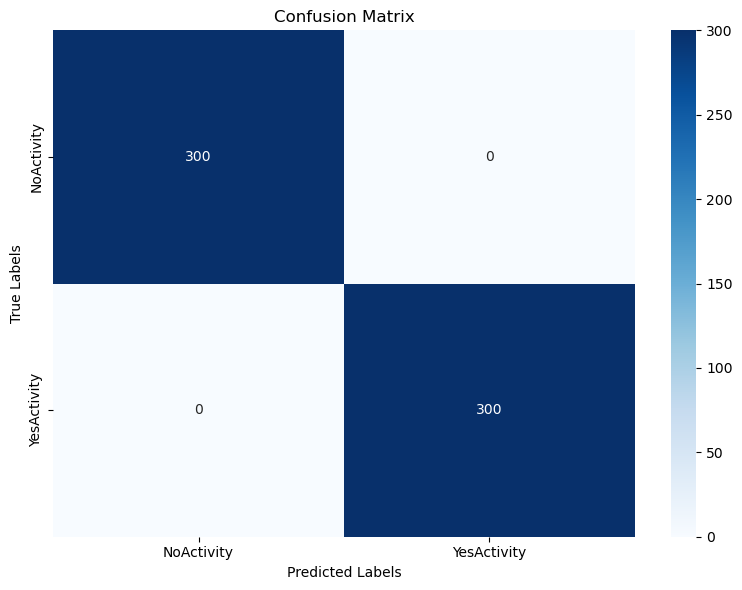

In [6]:
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Function to load and test the saved model
def test_saved_model(model_path, test_loader, class_names):
    # Load the saved model
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    # Inference on the test set
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate classification report
    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    print(pd.DataFrame(report).transpose())

    # Generate confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)

    return report, cm

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names, plot_path):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(plot_path, format="jpg")
    plt.show()

# Test the model on the test dataset
saved_model_path = "F:/Volcanic Activity Detection/best_model.pth"
report, confusion_matrix_output = test_saved_model(saved_model_path, test_loader, train_dataset.classes)

# Optionally save the classification report and confusion matrix as CSV files
# Save classification report
report_df = pd.DataFrame(report).transpose()
report_df.to_csv("classification_report.csv", index=True)

# Save confusion matrix
cm_df = pd.DataFrame(confusion_matrix_output, index=train_dataset.classes, columns=train_dataset.classes)
cm_df.to_csv("confusion_matrix.csv", index=True)

# Plot and save confusion matrix as JPG
plot_path = "F:/Volcanic Activity Detection/confusion_matrix_plot.jpg"
plot_confusion_matrix(confusion_matrix_output, train_dataset.classes, plot_path)

## Explainable AI

Using device: cpu


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\HP\AppData\Local\Temp\ipykernel_22492\584998596.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `wei

  0%|          | 0/1000 [00:00<?, ?it/s]

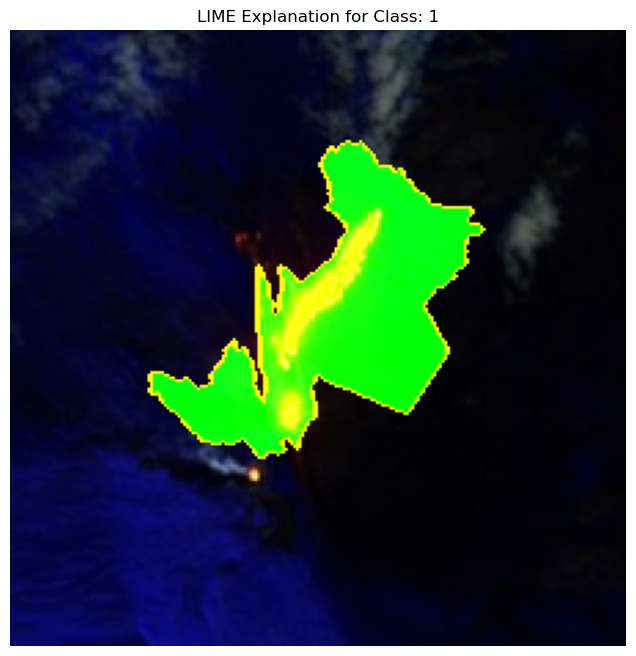

In [ ]:
# Explainability on YesActivity Volcanic Activity

import torch
from PIL import Image
from transformers import SwinForImageClassification, AutoImageProcessor
from lime import lime_image
from skimage.segmentation import slic, mark_boundaries
import numpy as np
import matplotlib.pyplot as plt

# Path to the saved model and test image
model_path = "F:/Volcanic Activity Detection/best_model.pth"
test_image_path = "F:/Volcanic Activity Detection/LastUpdate/test/YesActivity/YesActivity_original_Image11.png_4ae7742a-bc6b-4d2a-a573-9d7f7d99b934.png"

# Device setup
device = torch.device("cpu")
print(f"Using device: {device}")

# Initialize the image processor and model
model_name = "microsoft/swin-tiny-patch4-window7-224"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = SwinForImageClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification
    ignore_mismatched_sizes=True
)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
model.to(device)

# Load and preprocess the test image using the image processor
def preprocess_image(image_path):
    image = Image.open(image_path)
    if image.mode != "RGB":
        image = image.convert("RGB")  # Ensure the image is in RGB format
    original_image = np.array(image)  # Store the original image for LIME
    
    # Process the image for model input, ensuring the correct shape and dimensions
    inputs = image_processor(images=image, return_tensors="pt")
    return original_image, inputs['pixel_values']

original_image, processed_image = preprocess_image(test_image_path)

# Ensure the processed image has the correct number of channels (RGB) and add batch dimension
processed_image = processed_image.squeeze(0)  # Remove the batch dimension if it exists
processed_image = processed_image.permute(1, 2, 0).numpy()  # Convert tensor to HWC format (Height x Width x Channels)
processed_image_batch = np.expand_dims(processed_image, axis=0)  # Add batch dimension (1, height, width, channels)

# Define the prediction function for LIME
def predict_fn(images):
    # Ensure the input images are in the correct shape and moved to the correct device
    images_tensor = torch.tensor(images).to(device).float()  # Convert to tensor and move to device
    images_tensor = images_tensor.permute(0, 3, 1, 2)  # Change shape to (batch_size, channels, height, width)
    with torch.no_grad():
        logits = model(images_tensor).logits
        probabilities = torch.nn.functional.softmax(logits, dim=1)
    return probabilities.cpu().numpy()
# Get the label predicted by the model
predicted_label = np.argmax(predict_fn(processed_image_batch))  # Pass the batched image

# Initialize the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the selected image prediction using LIME
explanation = explainer.explain_instance(
    original_image,
    predict_fn,
    top_labels=2,                   # Number of top labels to consider
    hide_color=0,                   # Color to use for hidden superpixels
    num_samples=1000,               # Number of perturbation samples
    segmentation_fn=lambda x: slic(x, n_segments=50, compactness=10)  # Superpixel segmentation
)

# Visualize the explanation
temp, mask = explanation.get_image_and_mask(
    label=predicted_label,
    positive_only=False,            # Show both positive and negative contributions
    num_features=5,                 # Number of superpixels to highlight
    hide_rest=False                 # Whether to hide the rest of the image
)

# Plot the explanation
plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(temp / 255.0, mask))  # Mark boundaries directly from skimage
plt.title(f"LIME Explanation for Class: {predicted_label}")
plt.axis('off')
plt.show()


In [ ]:
# Explainability on YesActivity Volcanic Activity

import torch
from PIL import Image
from transformers import SwinForImageClassification, AutoImageProcessor
from lime import lime_image
from skimage.segmentation import slic, mark_boundaries
import numpy as np
import matplotlib.pyplot as plt

# Path to the saved model and test image
model_path = "F:/Volcanic Activity Detection/best_model.pth"
test_image_path = "F:/Volcanic Activity Detection/LastUpdate/test/YesActivity/YesActivity_original_Image12.png_1acdc754-9dee-4c74-8684-6c9209d8d255.png"

# Device setup
device = torch.device("cpu")
print(f"Using device: {device}")

# Initialize the image processor and model
model_name = "microsoft/swin-tiny-patch4-window7-224"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = SwinForImageClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification
    ignore_mismatched_sizes=True
)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
model.to(device)

# Load and preprocess the test image using the image processor
def preprocess_image(image_path):
    image = Image.open(image_path)
    if image.mode != "RGB":
        image = image.convert("RGB")  # Ensure the image is in RGB format
    original_image = np.array(image)  # Store the original image for LIME
    
    # Process the image for model input, ensuring the correct shape and dimensions
    inputs = image_processor(images=image, return_tensors="pt")
    return original_image, inputs['pixel_values']

original_image, processed_image = preprocess_image(test_image_path)

# Ensure the processed image has the correct number of channels (RGB) and add batch dimension
processed_image = processed_image.squeeze(0)  # Remove the batch dimension if it exists
processed_image = processed_image.permute(1, 2, 0).numpy()  # Convert tensor to HWC format (Height x Width x Channels)
processed_image_batch = np.expand_dims(processed_image, axis=0)  # Add batch dimension (1, height, width, channels)

# Define the prediction function for LIME
def predict_fn(images):
    # Ensure the input images are in the correct shape and moved to the correct device
    images_tensor = torch.tensor(images).to(device).float()  # Convert to tensor and move to device
    images_tensor = images_tensor.permute(0, 3, 1, 2)  # Change shape to (batch_size, channels, height, width)
    with torch.no_grad():
        logits = model(images_tensor).logits
        probabilities = torch.nn.functional.softmax(logits, dim=1)
    return probabilities.cpu().numpy()
# Get the label predicted by the model
predicted_label = np.argmax(predict_fn(processed_image_batch))  # Pass the batched image

# Initialize the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the selected image prediction using LIME
explanation = explainer.explain_instance(
    original_image,
    predict_fn,
    top_labels=2,                   # Number of top labels to consider
    hide_color=0,                   # Color to use for hidden superpixels
    num_samples=1000,               # Number of perturbation samples
    segmentation_fn=lambda x: slic(x, n_segments=50, compactness=10)  # Superpixel segmentation
)

# Visualize the explanation
temp, mask = explanation.get_image_and_mask(
    label=predicted_label,
    positive_only=False,            # Show both positive and negative contributions
    num_features=5,                 # Number of superpixels to highlight
    hide_rest=False                 # Whether to hide the rest of the image
)

# Plot the explanation
plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(temp / 255.0, mask))  # Mark boundaries directly from skimage
plt.title(f"LIME Explanation for Class: {predicted_label}")
plt.axis('off')
plt.show()

Using device: cpu


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\HP\AppData\Local\Temp\ipykernel_22492\1233149217.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `we

  0%|          | 0/1000 [00:00<?, ?it/s]

Using device: cpu


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\HP\AppData\Local\Temp\ipykernel_22492\2535482533.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `we

  0%|          | 0/1000 [00:00<?, ?it/s]

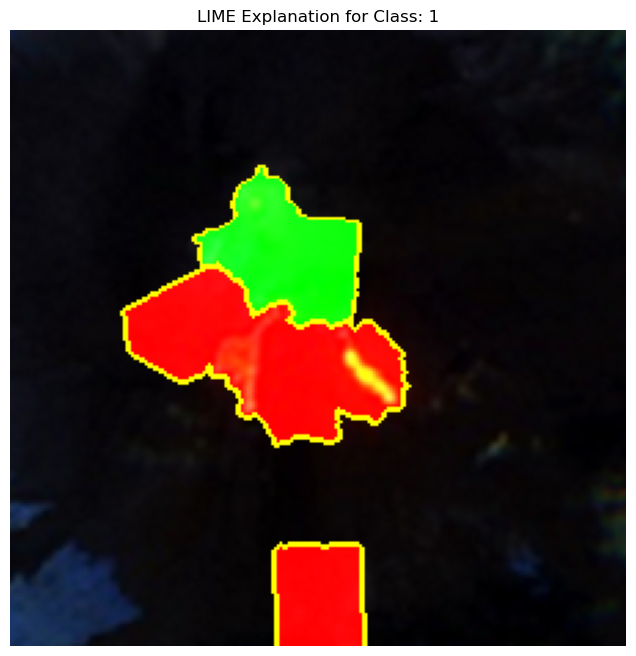

In [ ]:
import torch
from PIL import Image
from transformers import SwinForImageClassification, AutoImageProcessor
from lime import lime_image
from skimage.segmentation import slic, mark_boundaries
import numpy as np
import matplotlib.pyplot as plt

# Path to the saved model and test image
model_path = "F:/Volcanic Activity Detection/best_model.pth"
test_image_path = "F:/Volcanic Activity Detection/LastUpdate/test/YesActivity/YesActivity_original_Image19.png_1c7e929a-b814-4d7d-85b1-c13d73372e46.png"

# Device setup
device = torch.device("cpu")
print(f"Using device: {device}")

# Initialize the image processor and model
model_name = "microsoft/swin-tiny-patch4-window7-224"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = SwinForImageClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification
    ignore_mismatched_sizes=True
)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
model.to(device)

# Load and preprocess the test image using the image processor
def preprocess_image(image_path):
    image = Image.open(image_path)
    if image.mode != "RGB":
        image = image.convert("RGB")  # Ensure the image is in RGB format
    original_image = np.array(image)  # Store the original image for LIME
    
    # Process the image for model input, ensuring the correct shape and dimensions
    inputs = image_processor(images=image, return_tensors="pt")
    return original_image, inputs['pixel_values']

original_image, processed_image = preprocess_image(test_image_path)

# Ensure the processed image has the correct number of channels (RGB) and add batch dimension
processed_image = processed_image.squeeze(0)  # Remove the batch dimension if it exists
processed_image = processed_image.permute(1, 2, 0).numpy()  # Convert tensor to HWC format (Height x Width x Channels)
processed_image_batch = np.expand_dims(processed_image, axis=0)  # Add batch dimension (1, height, width, channels)

# Define the prediction function for LIME
def predict_fn(images):
    # Ensure the input images are in the correct shape and moved to the correct device
    images_tensor = torch.tensor(images).to(device).float()  # Convert to tensor and move to device
    images_tensor = images_tensor.permute(0, 3, 1, 2)  # Change shape to (batch_size, channels, height, width)
    with torch.no_grad():
        logits = model(images_tensor).logits
        probabilities = torch.nn.functional.softmax(logits, dim=1)
    return probabilities.cpu().numpy()
# Get the label predicted by the model
predicted_label = np.argmax(predict_fn(processed_image_batch))  # Pass the batched image

# Initialize the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the selected image prediction using LIME
explanation = explainer.explain_instance(
    original_image,
    predict_fn,
    top_labels=2,                   # Number of top labels to consider
    hide_color=0,                   # Color to use for hidden superpixels
    num_samples=1000,               # Number of perturbation samples
    segmentation_fn=lambda x: slic(x, n_segments=50, compactness=10)  # Superpixel segmentation
)

# Visualize the explanation
temp, mask = explanation.get_image_and_mask(
    label=predicted_label,
    positive_only=False,            # Show both positive and negative contributions
    num_features=5,                 # Number of superpixels to highlight
    hide_rest=False                 # Whether to hide the rest of the image
)

# Plot the explanation
plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(temp / 255.0, mask))  # Mark boundaries directly from skimage
plt.title(f"LIME Explanation for Class: {predicted_label}")
plt.axis('off')
plt.show()


Using device: cpu


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\HP\AppData\Local\Temp\ipykernel_22492\1745481515.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `we

  0%|          | 0/1000 [00:00<?, ?it/s]

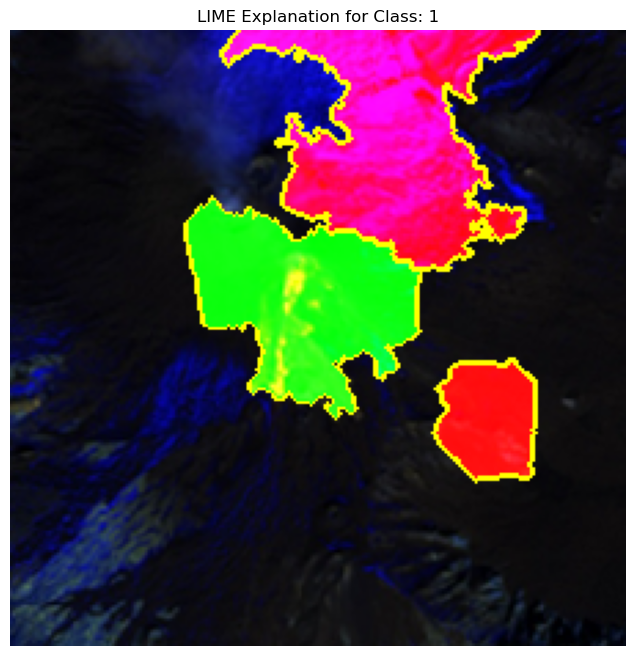

In [ ]:
import torch
from PIL import Image
from transformers import SwinForImageClassification, AutoImageProcessor
from lime import lime_image
from skimage.segmentation import slic, mark_boundaries
import numpy as np
import matplotlib.pyplot as plt

# Path to the saved model and test image
model_path = "F:/Volcanic Activity Detection/best_model.pth"
test_image_path = "F:/Volcanic Activity Detection/LastUpdate/test/YesActivity/YesActivity_original_Image20.png_0b1a7c1c-a804-403f-b07c-6be0cd858566.png"

# Device setup
device = torch.device("cpu")
print(f"Using device: {device}")

# Initialize the image processor and model
model_name = "microsoft/swin-tiny-patch4-window7-224"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = SwinForImageClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification
    ignore_mismatched_sizes=True
)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
model.to(device)

# Load and preprocess the test image using the image processor
def preprocess_image(image_path):
    image = Image.open(image_path)
    if image.mode != "RGB":
        image = image.convert("RGB")  # Ensure the image is in RGB format
    original_image = np.array(image)  # Store the original image for LIME
    
    # Process the image for model input, ensuring the correct shape and dimensions
    inputs = image_processor(images=image, return_tensors="pt")
    return original_image, inputs['pixel_values']

original_image, processed_image = preprocess_image(test_image_path)

# Ensure the processed image has the correct number of channels (RGB) and add batch dimension
processed_image = processed_image.squeeze(0)  # Remove the batch dimension if it exists
processed_image = processed_image.permute(1, 2, 0).numpy()  # Convert tensor to HWC format (Height x Width x Channels)
processed_image_batch = np.expand_dims(processed_image, axis=0)  # Add batch dimension (1, height, width, channels)

# Define the prediction function for LIME
def predict_fn(images):
    # Ensure the input images are in the correct shape and moved to the correct device
    images_tensor = torch.tensor(images).to(device).float()  # Convert to tensor and move to device
    images_tensor = images_tensor.permute(0, 3, 1, 2)  # Change shape to (batch_size, channels, height, width)
    with torch.no_grad():
        logits = model(images_tensor).logits
        probabilities = torch.nn.functional.softmax(logits, dim=1)
    return probabilities.cpu().numpy()
# Get the label predicted by the model
predicted_label = np.argmax(predict_fn(processed_image_batch))  # Pass the batched image

# Initialize the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the selected image prediction using LIME
explanation = explainer.explain_instance(
    original_image,
    predict_fn,
    top_labels=2,                   # Number of top labels to consider
    hide_color=0,                   # Color to use for hidden superpixels
    num_samples=1000,               # Number of perturbation samples
    segmentation_fn=lambda x: slic(x, n_segments=50, compactness=10)  # Superpixel segmentation
)

# Visualize the explanation
temp, mask = explanation.get_image_and_mask(
    label=predicted_label,
    positive_only=False,            # Show both positive and negative contributions
    num_features=5,                 # Number of superpixels to highlight
    hide_rest=False                 # Whether to hide the rest of the image
)

# Plot the explanation
plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(temp / 255.0, mask))  # Mark boundaries directly from skimage
plt.title(f"LIME Explanation for Class: {predicted_label}")
plt.axis('off')
plt.show()


In [ ]:
import torch
from PIL import Image
from transformers import SwinForImageClassification, AutoImageProcessor
from lime import lime_image
from skimage.segmentation import slic, mark_boundaries
import numpy as np
import matplotlib.pyplot as plt

# Path to the saved model and test image
model_path = "F:/Volcanic Activity Detection/best_model.pth"
test_image_path = "F:/Volcanic Activity Detection/LastUpdate/test/YesActivity/YesActivity_original_Image24.png_2c5e9cb4-4c0a-4bad-b029-47b255858845.png"

# Device setup
device = torch.device("cpu")
print(f"Using device: {device}")

# Initialize the image processor and model
model_name = "microsoft/swin-tiny-patch4-window7-224"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = SwinForImageClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification
    ignore_mismatched_sizes=True
)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
model.to(device)

# Load and preprocess the test image using the image processor
def preprocess_image(image_path):
    image = Image.open(image_path)
    if image.mode != "RGB":
        image = image.convert("RGB")  # Ensure the image is in RGB format
    original_image = np.array(image)  # Store the original image for LIME
    
    # Process the image for model input, ensuring the correct shape and dimensions
    inputs = image_processor(images=image, return_tensors="pt")
    return original_image, inputs['pixel_values']

original_image, processed_image = preprocess_image(test_image_path)

# Ensure the processed image has the correct number of channels (RGB) and add batch dimension
processed_image = processed_image.squeeze(0)  # Remove the batch dimension if it exists
processed_image = processed_image.permute(1, 2, 0).numpy()  # Convert tensor to HWC format (Height x Width x Channels)
processed_image_batch = np.expand_dims(processed_image, axis=0)  # Add batch dimension (1, height, width, channels)

# Define the prediction function for LIME
def predict_fn(images):
    # Ensure the input images are in the correct shape and moved to the correct device
    images_tensor = torch.tensor(images).to(device).float()  # Convert to tensor and move to device
    images_tensor = images_tensor.permute(0, 3, 1, 2)  # Change shape to (batch_size, channels, height, width)
    with torch.no_grad():
        logits = model(images_tensor).logits
        probabilities = torch.nn.functional.softmax(logits, dim=1)
    return probabilities.cpu().numpy()
# Get the label predicted by the model
predicted_label = np.argmax(predict_fn(processed_image_batch))  # Pass the batched image

# Initialize the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the selected image prediction using LIME
explanation = explainer.explain_instance(
    original_image,
    predict_fn,
    top_labels=2,                   # Number of top labels to consider
    hide_color=0,                   # Color to use for hidden superpixels
    num_samples=1000,               # Number of perturbation samples
    segmentation_fn=lambda x: slic(x, n_segments=50, compactness=10)  # Superpixel segmentation
)

# Visualize the explanation
temp, mask = explanation.get_image_and_mask(
    label=predicted_label,
    positive_only=False,            # Show both positive and negative contributions
    num_features=5,                 # Number of superpixels to highlight
    hide_rest=False                 # Whether to hide the rest of the image
)

# Plot the explanation
plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(temp / 255.0, mask))  # Mark boundaries directly from skimage
plt.title(f"LIME Explanation for Class: {predicted_label}")
plt.axis('off')
plt.show()

Using device: cpu


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\HP\AppData\Local\Temp\ipykernel_22492\879268418.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `wei

  0%|          | 0/1000 [00:00<?, ?it/s]

Using device: cpu


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\HP\AppData\Local\Temp\ipykernel_22492\134740783.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `wei

  0%|          | 0/1000 [00:00<?, ?it/s]

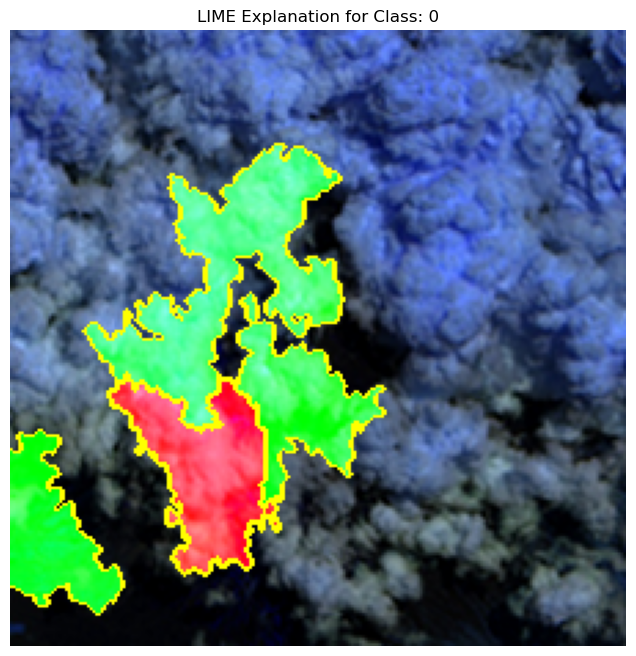

In [ ]:
import torch
from PIL import Image
from transformers import SwinForImageClassification, AutoImageProcessor
from lime import lime_image
from skimage.segmentation import slic, mark_boundaries
import numpy as np
import matplotlib.pyplot as plt

# Path to the saved model and test image
model_path = "F:/Volcanic Activity Detection/best_model.pth"
test_image_path = "F:/Volcanic Activity Detection/LastUpdate/test/NoActivity/NoActivity_original_Image11.png_0d5c2e26-5381-44ce-82db-235c2a82eb82.png"

# Device setup
device = torch.device("cpu")
print(f"Using device: {device}")

# Initialize the image processor and model
model_name = "microsoft/swin-tiny-patch4-window7-224"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = SwinForImageClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification
    ignore_mismatched_sizes=True
)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
model.to(device)

# Load and preprocess the test image using the image processor
def preprocess_image(image_path):
    image = Image.open(image_path)
    if image.mode != "RGB":
        image = image.convert("RGB")  # Ensure the image is in RGB format
    original_image = np.array(image)  # Store the original image for LIME
    
    # Process the image for model input, ensuring the correct shape and dimensions
    inputs = image_processor(images=image, return_tensors="pt")
    return original_image, inputs['pixel_values']

original_image, processed_image = preprocess_image(test_image_path)

# Ensure the processed image has the correct number of channels (RGB) and add batch dimension
processed_image = processed_image.squeeze(0)  # Remove the batch dimension if it exists
processed_image = processed_image.permute(1, 2, 0).numpy()  # Convert tensor to HWC format (Height x Width x Channels)
processed_image_batch = np.expand_dims(processed_image, axis=0)  # Add batch dimension (1, height, width, channels)

# Define the prediction function for LIME
def predict_fn(images):
    # Ensure the input images are in the correct shape and moved to the correct device
    images_tensor = torch.tensor(images).to(device).float()  # Convert to tensor and move to device
    images_tensor = images_tensor.permute(0, 3, 1, 2)  # Change shape to (batch_size, channels, height, width)
    with torch.no_grad():
        logits = model(images_tensor).logits
        probabilities = torch.nn.functional.softmax(logits, dim=1)
    return probabilities.cpu().numpy()
# Get the label predicted by the model
predicted_label = np.argmax(predict_fn(processed_image_batch))  # Pass the batched image

# Initialize the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the selected image prediction using LIME
explanation = explainer.explain_instance(
    original_image,
    predict_fn,
    top_labels=2,                   # Number of top labels to consider
    hide_color=0,                   # Color to use for hidden superpixels
    num_samples=1000,               # Number of perturbation samples
    segmentation_fn=lambda x: slic(x, n_segments=50, compactness=10)  # Superpixel segmentation
)

# Visualize the explanation
temp, mask = explanation.get_image_and_mask(
    label=predicted_label,
    positive_only=False,            # Show both positive and negative contributions
    num_features=5,                 # Number of superpixels to highlight
    hide_rest=False                 # Whether to hide the rest of the image
)

# Plot the explanation
plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(temp / 255.0, mask))  # Mark boundaries directly from skimage
plt.title(f"LIME Explanation for Class: {predicted_label}")
plt.axis('off')
plt.show()


Using device: cpu


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\HP\AppData\Local\Temp\ipykernel_22492\1336067375.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `we

  0%|          | 0/1000 [00:00<?, ?it/s]

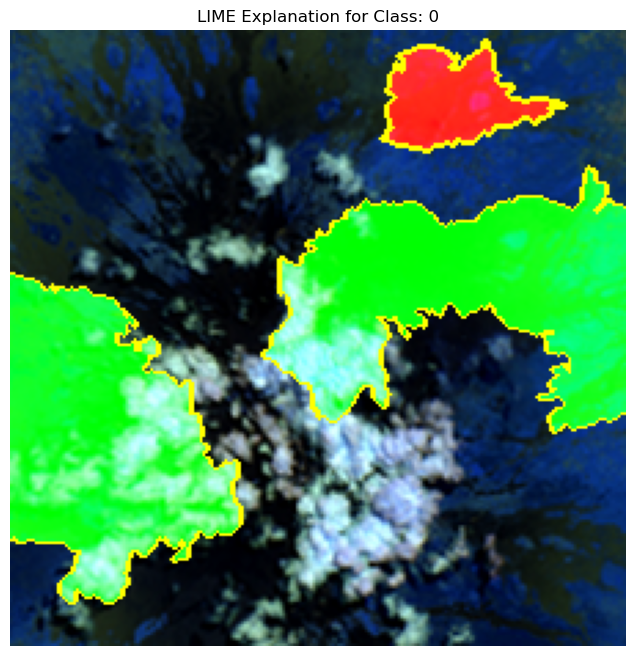

In [ ]:
import torch
from PIL import Image
from transformers import SwinForImageClassification, AutoImageProcessor
from lime import lime_image
from skimage.segmentation import slic, mark_boundaries
import numpy as np
import matplotlib.pyplot as plt

# Path to the saved model and test image
model_path = "F:/Volcanic Activity Detection/best_model.pth"
test_image_path = "F:/Volcanic Activity Detection/LastUpdate/test/NoActivity/NoActivity_original_Image12.png_2f962f96-06ee-48ff-bf9e-c6aeb2428e3e.png"

# Device setup
device = torch.device("cpu")
print(f"Using device: {device}")

# Initialize the image processor and model
model_name = "microsoft/swin-tiny-patch4-window7-224"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = SwinForImageClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification
    ignore_mismatched_sizes=True
)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
model.to(device)

# Load and preprocess the test image using the image processor
def preprocess_image(image_path):
    image = Image.open(image_path)
    if image.mode != "RGB":
        image = image.convert("RGB")  # Ensure the image is in RGB format
    original_image = np.array(image)  # Store the original image for LIME
    
    # Process the image for model input, ensuring the correct shape and dimensions
    inputs = image_processor(images=image, return_tensors="pt")
    return original_image, inputs['pixel_values']

original_image, processed_image = preprocess_image(test_image_path)

# Ensure the processed image has the correct number of channels (RGB) and add batch dimension
processed_image = processed_image.squeeze(0)  # Remove the batch dimension if it exists
processed_image = processed_image.permute(1, 2, 0).numpy()  # Convert tensor to HWC format (Height x Width x Channels)
processed_image_batch = np.expand_dims(processed_image, axis=0)  # Add batch dimension (1, height, width, channels)

# Define the prediction function for LIME
def predict_fn(images):
    # Ensure the input images are in the correct shape and moved to the correct device
    images_tensor = torch.tensor(images).to(device).float()  # Convert to tensor and move to device
    images_tensor = images_tensor.permute(0, 3, 1, 2)  # Change shape to (batch_size, channels, height, width)
    with torch.no_grad():
        logits = model(images_tensor).logits
        probabilities = torch.nn.functional.softmax(logits, dim=1)
    return probabilities.cpu().numpy()
# Get the label predicted by the model
predicted_label = np.argmax(predict_fn(processed_image_batch))  # Pass the batched image

# Initialize the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the selected image prediction using LIME
explanation = explainer.explain_instance(
    original_image,
    predict_fn,
    top_labels=2,                   # Number of top labels to consider
    hide_color=0,                   # Color to use for hidden superpixels
    num_samples=1000,               # Number of perturbation samples
    segmentation_fn=lambda x: slic(x, n_segments=50, compactness=10)  # Superpixel segmentation
)

# Visualize the explanation
temp, mask = explanation.get_image_and_mask(
    label=predicted_label,
    positive_only=False,            # Show both positive and negative contributions
    num_features=5,                 # Number of superpixels to highlight
    hide_rest=False                 # Whether to hide the rest of the image
)

# Plot the explanation
plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(temp / 255.0, mask))  # Mark boundaries directly from skimage
plt.title(f"LIME Explanation for Class: {predicted_label}")
plt.axis('off')
plt.show()


Using device: cpu


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\HP\AppData\Local\Temp\ipykernel_22492\1309072268.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `we

  0%|          | 0/1000 [00:00<?, ?it/s]

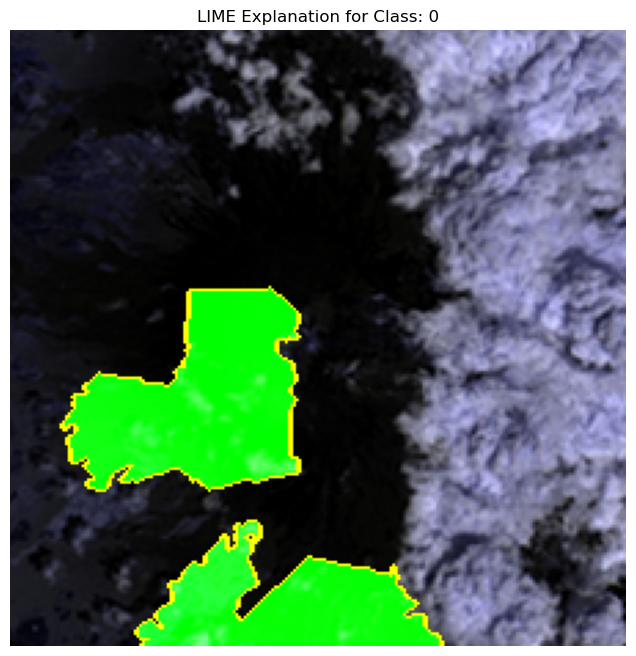

In [ ]:
import torch
from PIL import Image
from transformers import SwinForImageClassification, AutoImageProcessor
from lime import lime_image
from skimage.segmentation import slic, mark_boundaries
import numpy as np
import matplotlib.pyplot as plt

# Path to the saved model and test image
model_path = "F:/Volcanic Activity Detection/best_model.pth"
test_image_path = "F:/Volcanic Activity Detection/LastUpdate/test/NoActivity/NoActivity_original_Image19.png_0edd6413-0ccb-44ea-875c-2f0770cc19c4.png"

# Device setup
device = torch.device("cpu")
print(f"Using device: {device}")

# Initialize the image processor and model
model_name = "microsoft/swin-tiny-patch4-window7-224"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = SwinForImageClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification
    ignore_mismatched_sizes=True
)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
model.to(device)

# Load and preprocess the test image using the image processor
def preprocess_image(image_path):
    image = Image.open(image_path)
    if image.mode != "RGB":
        image = image.convert("RGB")  # Ensure the image is in RGB format
    original_image = np.array(image)  # Store the original image for LIME
    
    # Process the image for model input, ensuring the correct shape and dimensions
    inputs = image_processor(images=image, return_tensors="pt")
    return original_image, inputs['pixel_values']

original_image, processed_image = preprocess_image(test_image_path)

# Ensure the processed image has the correct number of channels (RGB) and add batch dimension
processed_image = processed_image.squeeze(0)  # Remove the batch dimension if it exists
processed_image = processed_image.permute(1, 2, 0).numpy()  # Convert tensor to HWC format (Height x Width x Channels)
processed_image_batch = np.expand_dims(processed_image, axis=0)  # Add batch dimension (1, height, width, channels)

# Define the prediction function for LIME
def predict_fn(images):
    # Ensure the input images are in the correct shape and moved to the correct device
    images_tensor = torch.tensor(images).to(device).float()  # Convert to tensor and move to device
    images_tensor = images_tensor.permute(0, 3, 1, 2)  # Change shape to (batch_size, channels, height, width)
    with torch.no_grad():
        logits = model(images_tensor).logits
        probabilities = torch.nn.functional.softmax(logits, dim=1)
    return probabilities.cpu().numpy()
# Get the label predicted by the model
predicted_label = np.argmax(predict_fn(processed_image_batch))  # Pass the batched image

# Initialize the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the selected image prediction using LIME
explanation = explainer.explain_instance(
    original_image,
    predict_fn,
    top_labels=2,                   # Number of top labels to consider
    hide_color=0,                   # Color to use for hidden superpixels
    num_samples=1000,               # Number of perturbation samples
    segmentation_fn=lambda x: slic(x, n_segments=50, compactness=10)  # Superpixel segmentation
)

# Visualize the explanation
temp, mask = explanation.get_image_and_mask(
    label=predicted_label,
    positive_only=False,            # Show both positive and negative contributions
    num_features=5,                 # Number of superpixels to highlight
    hide_rest=False                 # Whether to hide the rest of the image
)

# Plot the explanation
plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(temp / 255.0, mask))  # Mark boundaries directly from skimage
plt.title(f"LIME Explanation for Class: {predicted_label}")
plt.axis('off')
plt.show()


Using device: cpu


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\HP\AppData\Local\Temp\ipykernel_22492\577398580.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `wei

  0%|          | 0/1000 [00:00<?, ?it/s]

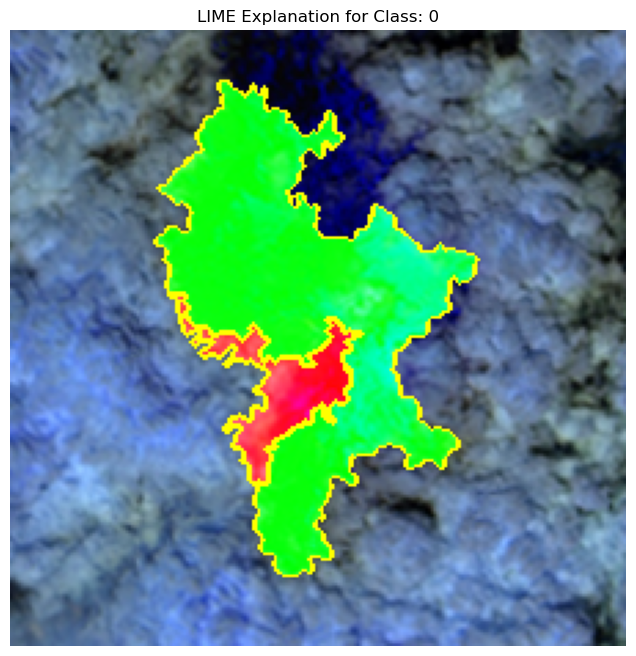

In [ ]:
import torch
from PIL import Image
from transformers import SwinForImageClassification, AutoImageProcessor
from lime import lime_image
from skimage.segmentation import slic, mark_boundaries
import numpy as np
import matplotlib.pyplot as plt

# Path to the saved model and test image
model_path = "F:/Volcanic Activity Detection/best_model.pth"
test_image_path = "F:/Volcanic Activity Detection/LastUpdate/test/NoActivity/NoActivity_original_Image20.png_8f3b8965-765e-452b-b8fd-fac960bfba7d.png"

# Device setup
device = torch.device("cpu")
print(f"Using device: {device}")

# Initialize the image processor and model
model_name = "microsoft/swin-tiny-patch4-window7-224"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = SwinForImageClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification
    ignore_mismatched_sizes=True
)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
model.to(device)

# Load and preprocess the test image using the image processor
def preprocess_image(image_path):
    image = Image.open(image_path)
    if image.mode != "RGB":
        image = image.convert("RGB")  # Ensure the image is in RGB format
    original_image = np.array(image)  # Store the original image for LIME
    
    # Process the image for model input, ensuring the correct shape and dimensions
    inputs = image_processor(images=image, return_tensors="pt")
    return original_image, inputs['pixel_values']

original_image, processed_image = preprocess_image(test_image_path)

# Ensure the processed image has the correct number of channels (RGB) and add batch dimension
processed_image = processed_image.squeeze(0)  # Remove the batch dimension if it exists
processed_image = processed_image.permute(1, 2, 0).numpy()  # Convert tensor to HWC format (Height x Width x Channels)
processed_image_batch = np.expand_dims(processed_image, axis=0)  # Add batch dimension (1, height, width, channels)

# Define the prediction function for LIME
def predict_fn(images):
    # Ensure the input images are in the correct shape and moved to the correct device
    images_tensor = torch.tensor(images).to(device).float()  # Convert to tensor and move to device
    images_tensor = images_tensor.permute(0, 3, 1, 2)  # Change shape to (batch_size, channels, height, width)
    with torch.no_grad():
        logits = model(images_tensor).logits
        probabilities = torch.nn.functional.softmax(logits, dim=1)
    return probabilities.cpu().numpy()
# Get the label predicted by the model
predicted_label = np.argmax(predict_fn(processed_image_batch))  # Pass the batched image

# Initialize the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the selected image prediction using LIME
explanation = explainer.explain_instance(
    original_image,
    predict_fn,
    top_labels=2,                   # Number of top labels to consider
    hide_color=0,                   # Color to use for hidden superpixels
    num_samples=1000,               # Number of perturbation samples
    segmentation_fn=lambda x: slic(x, n_segments=50, compactness=10)  # Superpixel segmentation
)

# Visualize the explanation
temp, mask = explanation.get_image_and_mask(
    label=predicted_label,
    positive_only=False,            # Show both positive and negative contributions
    num_features=5,                 # Number of superpixels to highlight
    hide_rest=False                 # Whether to hide the rest of the image
)

# Plot the explanation
plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(temp / 255.0, mask))  # Mark boundaries directly from skimage
plt.title(f"LIME Explanation for Class: {predicted_label}")
plt.axis('off')
plt.show()


Using device: cpu


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\HP\AppData\Local\Temp\ipykernel_22492\3477981707.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `we

  0%|          | 0/1000 [00:00<?, ?it/s]

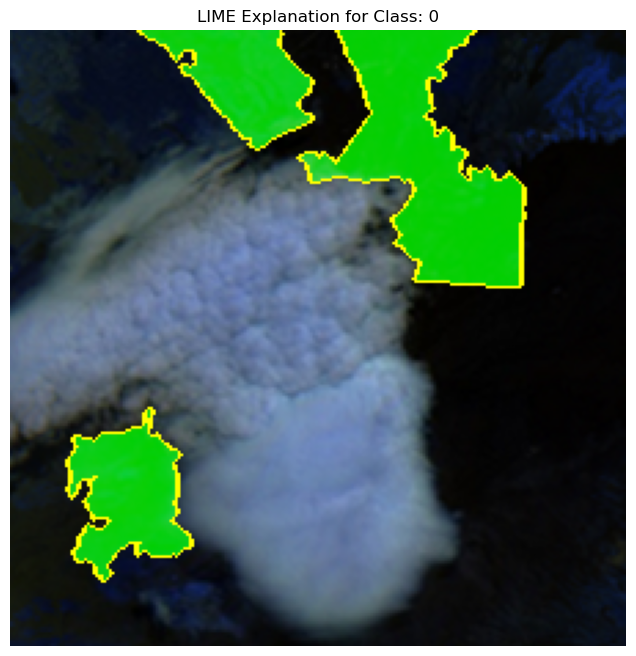

In [ ]:
import torch
from PIL import Image
from transformers import SwinForImageClassification, AutoImageProcessor
from lime import lime_image
from skimage.segmentation import slic, mark_boundaries
import numpy as np
import matplotlib.pyplot as plt

# Path to the saved model and test image
model_path = "F:/Volcanic Activity Detection/best_model.pth"
test_image_path = "F:/Volcanic Activity Detection/LastUpdate/test/NoActivity/NoActivity_original_Image21.png_5c63a643-9010-43ee-8bb4-3cf04de26f30.png"

# Device setup
device = torch.device("cpu")
print(f"Using device: {device}")

# Initialize the image processor and model
model_name = "microsoft/swin-tiny-patch4-window7-224"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = SwinForImageClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification
    ignore_mismatched_sizes=True
)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
model.to(device)

# Load and preprocess the test image using the image processor
def preprocess_image(image_path):
    image = Image.open(image_path)
    if image.mode != "RGB":
        image = image.convert("RGB")  # Ensure the image is in RGB format
    original_image = np.array(image)  # Store the original image for LIME
    
    # Process the image for model input, ensuring the correct shape and dimensions
    inputs = image_processor(images=image, return_tensors="pt")
    return original_image, inputs['pixel_values']

original_image, processed_image = preprocess_image(test_image_path)

# Ensure the processed image has the correct number of channels (RGB) and add batch dimension
processed_image = processed_image.squeeze(0)  # Remove the batch dimension if it exists
processed_image = processed_image.permute(1, 2, 0).numpy()  # Convert tensor to HWC format (Height x Width x Channels)
processed_image_batch = np.expand_dims(processed_image, axis=0)  # Add batch dimension (1, height, width, channels)

# Define the prediction function for LIME
def predict_fn(images):
    # Ensure the input images are in the correct shape and moved to the correct device
    images_tensor = torch.tensor(images).to(device).float()  # Convert to tensor and move to device
    images_tensor = images_tensor.permute(0, 3, 1, 2)  # Change shape to (batch_size, channels, height, width)
    with torch.no_grad():
        logits = model(images_tensor).logits
        probabilities = torch.nn.functional.softmax(logits, dim=1)
    return probabilities.cpu().numpy()
# Get the label predicted by the model
predicted_label = np.argmax(predict_fn(processed_image_batch))  # Pass the batched image

# Initialize the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the selected image prediction using LIME
explanation = explainer.explain_instance(
    original_image,
    predict_fn,
    top_labels=2,                   # Number of top labels to consider
    hide_color=0,                   # Color to use for hidden superpixels
    num_samples=1000,               # Number of perturbation samples
    segmentation_fn=lambda x: slic(x, n_segments=50, compactness=10)  # Superpixel segmentation
)

# Visualize the explanation
temp, mask = explanation.get_image_and_mask(
    label=predicted_label,
    positive_only=False,            # Show both positive and negative contributions
    num_features=5,                 # Number of superpixels to highlight
    hide_rest=False                 # Whether to hide the rest of the image
)

# Plot the explanation
plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(temp / 255.0, mask))  # Mark boundaries directly from skimage
plt.title(f"LIME Explanation for Class: {predicted_label}")
plt.axis('off')
plt.show()
